## Counting objects

In class, we saw how to count the number of objects in a microscopy image.  Here, we will repeat that exercise, but make use of some of the algorithms in `scikit-image` to segment the image, and then to determine properties of the resulting objects.

As input, use the image `skimage.data.coins`.  Segment the image, and then calculate the area and eccentricity of each coin.

There are various ways to do this.  One would be:

1. Equalize the input image (see `skimage.exposure`)
2. Threshold the image (`skimage.filters.otsu`)
3. Remove objects touching the boundary (`skimage.segmentation.clear_border`)
4. Apply morphological closing (`skimage.morphology.closing`)
5. Remove small objects (`skimage.measure.regionprops`).
   Visualize the results if you want with `skimage.color.label2rgb`.
7. Calculate the area and eccentricity of each coin, and display the
   original image with this information on it (`matplotlib.pyplot.text` or `matplotlib.pyplot.annotate`)

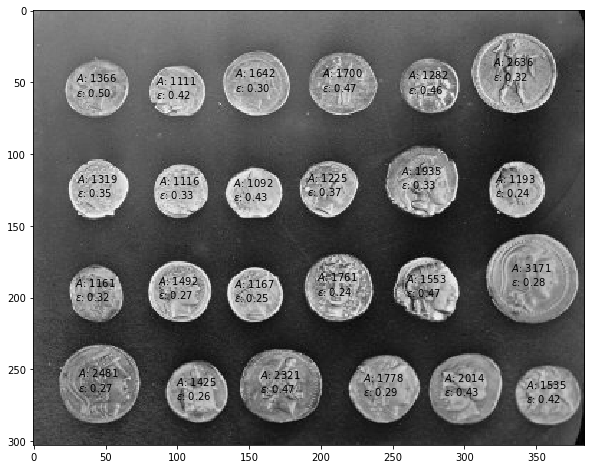

In [1]:
###
# COUNTING OBJECTS
###

import skimage
import skimage.data
import skimage.segmentation
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,8)

coins = skimage.data.coins()
coins_eq = skimage.exposure.equalize_hist(coins) #Equalize by making color histogram flat

#Threshold image - did this separately in 4 different quadrants of image because shift in background color between quadrants made some coins not show up when thresholding entire image
#Quadrants were shifted by hand to avoid cutting coin
sh = np.shape(coins)
coins_eq_quads = [coins_eq[:sh[0]//2-10,:sh[1]//2],coins_eq[sh[0]//2-10:,:sh[1]//2],coins_eq[:sh[0]//2-10,sh[1]//2:],coins_eq[sh[0]//2-10:,sh[1]//2:]]
thresh_quads = [skimage.filters.threshold_otsu(coins_eq_quad) for coins_eq_quad in coins_eq_quads]
coins_binary_quads = [coins_eq_quad <= thresh for coins_eq_quad,thresh in zip(coins_eq_quads,thresh_quads)]
coins_binary = np.hstack([np.vstack([coins_binary_quads[0],coins_binary_quads[1]]),np.vstack([coins_binary_quads[2],coins_binary_quads[3]])])

#Flip thresholded regions connected to the border
coins_noborder = skimage.segmentation.clear_border(np.invert(coins_binary))

#Morphological closing to get rid of (some of the) peppered spots & distortions
selem = skimage.morphology.disk(1)
coins_morph = skimage.morphology.binary_closing(coins_noborder,selem=selem)

#Remove small objects using skimage.morphology.remove_small_objects
coins_morph = skimage.morphology.remove_small_objects(coins_morph)
coins_morph = np.invert(skimage.morphology.remove_small_objects(np.invert(coins_morph)))

#Label image
label_image = skimage.measure.label(coins_morph)
image_label_overlay = skimage.color.label2rgb(label_image, image=coins_morph)

#Check that we've gotten all the coins and only the coins
#print(np.max(label_image)) #equals 24, as we can confirm visually

#Plot original image
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(coins,cmap=plt.cm.gray)

#Get properties of each region
regions = skimage.measure.regionprops(label_image)
#Annotate each coin with its area and eccentricity
for r in regions:
    area = r.area
    ecc = r.eccentricity
    coord = np.flip(np.asarray(r.centroid),axis=0)#coord is given as [y,x] so we have to flip it
    ax.annotate((r"$A$: %i" % area),coord - np.asarray([15,5])) 
    ax.annotate((r'$\epsilon$: %.2f' % ecc),coord - np.asarray([15,-5]))
    
plt.show()